<a href="https://colab.research.google.com/github/EngineeringErgonomics/open-interpreter/blob/main/Predicting_Stock_Prices_with_LSTM_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install pandas-ta

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas_ta as ta  # noqa
import matplotlib.pyplot as plt

# Step 1: Prepare the data
def create_sequences(feature_data, target_data, sequence_length):
    X, y = [], []
    for i in range(len(feature_data) - sequence_length):
        X.append(feature_data[i:(i + sequence_length)])
        y.append(target_data[i + sequence_length])
    return np.array(X), np.array(y)

# Define the sequence length (e.g., 30 days of historical data)
sequence_length = 30

# Select features for the model
features = ['Open', 'High', 'Low', 'Volume', 'close_delta', 'open_delta', 'high_delta', 'low_delta', 'volume_delta',
            'ema_8', 'ema_21', 'ema_34', 'ema_55', 'ema_89', 'macd_line', 'macd_signal_line', 'macd_histogram',
            'squeeze_pro_indicator', 'squeeze_pro_on_wide', 'squeeze_pro_on_normal', 'squeeze_pro_on_narrow',
            'squeeze_pro_off', 'squeeze_pro_no', 'squeeze_pro_increase', 'squeeze_pro_decrease',
            'squeeze_pro_potential_increase', 'squeeze_pro_potential_decrease', 'squeeze_pro_negative_decrease',
            'squeeze_pro_negative_increase']

target = 'Close'


In [36]:
from google.colab import drive
drive.mount("/content/drive")
content_root: str = "/content/drive/MyDrive/0SYSTEM/Masters_Program/data"
df: pd.DataFrame = pd.read_csv(f'{content_root}/SPY.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
df["close_delta"]: pd.DataFrame = df.Close.diff().fillna(0)
df["open_delta"]: pd.DataFrame = df.Open.diff().fillna(0)
df["high_delta"]: pd.DataFrame = df.High.diff().fillna(0)
df["low_delta"]: pd.DataFrame = df.Low.diff().fillna(0)
df["volume_delta"]: pd.DataFrame = df.Volume.diff().fillna(0)
try:
    df.drop(["Adj Close", "Date"], axis=1, inplace=True)
except KeyError:
    pass

df

,Open,High,Low,Close,Volume,close_delta,open_delta,high_delta,low_delta,volume_delta
0,43.968750,43.968750,43.750000,43.937500,1003200,0.000000,0.000000,0.000000,0.000000,0.0
1,43.968750,44.250000,43.968750,44.250000,480500,0.312500,0.000000,0.281250,0.218750,-522700.0
2,44.218750,44.375000,44.125000,44.343750,201300,0.093750,0.250000,0.125000,0.156250,-279200.0
3,44.406250,44.843750,44.375000,44.812500,529400,0.468750,0.187500,0.468750,0.250000,328100.0
4,44.968750,45.093750,44.468750,45.000000,531500,0.187500,0.562500,0.250000,0.093750,2100.0
...,...,...,...,...,...,...,...,...,...,...
7949,563.179993,563.909973,559.049988,560.789978,35788600,-1.340027,3.649964,0.819946,1.760010,-14850800.0
7950,559.489990,562.059998,558.320007,561.559998,32693900,0.770020,-3.690003,-1.849975,-0.729981,-3094700.0
7951,561.210022,561.650024,555.039978,558.299988,41066000,-3.260010,1.720032,-0.409974,-3.280029,8372100.0
7952,560.309998,563.679993,557.179993,558.349976,38715200,0.049988,-0.900024,2.029969,2.140015,-2350800.0


In [38]:
ticker_data = df

In [39]:
# Calculate EMAs
ticker_data["ema_8"] = ticker_data["Close"].ewm(span=8, adjust=False).mean()
ticker_data["ema_21"] = ticker_data["Close"].ewm(span=21, adjust=False).mean()
ticker_data["ema_34"] = ticker_data["Close"].ewm(span=34, adjust=False).mean()
ticker_data["ema_55"] = ticker_data["Close"].ewm(span=55, adjust=False).mean()
ticker_data["ema_89"] = ticker_data["Close"].ewm(span=89, adjust=False).mean()

In [40]:
# Calculate MACD
try:
    macd = ticker_data.ta.macd(
        close="Close", fast=12, slow=26, signal=9, append=True
    )
    ticker_data["macd_line"] = macd["MACD_12_26_9"]
    ticker_data["macd_signal_line"] = macd["MACDs_12_26_9"]
    ticker_data["macd_histogram"] = macd["MACDh_12_26_9"]
except TypeError:
    # Handle missing or None values
    ticker_data["macd_line"] = None
    ticker_data["macd_signal_line"] = None
    ticker_data["macd_histogram"] = None

In [41]:
# Calculate Squeeze Pro Indicators
squeeze = ticker_data.ta.squeeze_pro(lazybear=True, detailed=True, append=True)
ticker_data["squeeze_pro_indicator"] = squeeze["SQZPRO_20_2.0_20_2_1.5_1"]
ticker_data["squeeze_pro_on_wide"] = squeeze["SQZPRO_ON_WIDE"]
ticker_data["squeeze_pro_on_normal"] = squeeze["SQZPRO_ON_NORMAL"]
ticker_data["squeeze_pro_on_narrow"] = squeeze["SQZPRO_ON_NARROW"]
ticker_data["squeeze_pro_off"] = squeeze["SQZPRO_OFF"]
ticker_data["squeeze_pro_no"] = squeeze["SQZPRO_NO"]
ticker_data["squeeze_pro_increase"] = squeeze["SQZPRO_INC"]
ticker_data["squeeze_pro_decrease"] = squeeze["SQZPRO_DEC"]
ticker_data["squeeze_pro_potential_increase"] = squeeze["SQZPRO_PINC"]
ticker_data["squeeze_pro_potential_decrease"] = squeeze["SQZPRO_PDEC"]
ticker_data["squeeze_pro_negative_decrease"] = squeeze["SQZPRO_NDEC"]
ticker_data["squeeze_pro_negative_increase"] = squeeze["SQZPRO_NINC"]

In [42]:
df = ticker_data

In [43]:
df_filled = df.ffill()
# Now apply backward fill
df_filled = df_filled.bfill()
df = df_filled

In [44]:
print(df.describe())
print("\nNull values:")
print(df.isnull().sum())
print("\nInfinite values:")
print(np.isinf(df).sum())

              Open         High          Low        Close        Volume  \
count  7954.000000  7954.000000  7954.000000  7954.000000  7.954000e+03   
mean    177.849266   178.899106   176.697239   177.860691  8.401158e+07   
std     116.974219   117.565903   116.347727   117.005731  9.145994e+07   
min      43.343750    43.531250    42.812500    43.406250  5.200000e+03   
25%     106.412503   107.285000   105.500000   106.381250  1.056615e+07   
50%     133.154999   133.950004   132.245002   133.194999  6.289980e+07   
75%     216.992500   217.352497   216.020001   216.935001  1.140842e+08   
max     563.179993   565.159973   562.099976   564.859985  8.710263e+08   

       close_delta   open_delta   high_delta    low_delta  volume_delta  ...  \
count  7954.000000  7954.000000  7954.000000  7954.000000  7.954000e+03  ...   
mean      0.065344     0.064974     0.065405     0.064545  7.752653e+03  ...   
std       2.318545     2.277337     1.876077     2.129497  3.790915e+07  ...   
min 

In [45]:

from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler

# Prepare the dataset
feature_data = df[features].values
target_data = df[target].values

# Normalize the features
scalers = {}
scaled_feature_data = np.zeros_like(feature_data)
for i, feature in enumerate(features):
    if feature in ['Volume', 'volume_delta']:
        scalers[feature] = StandardScaler()
    else:
        scalers[feature] = MinMaxScaler(feature_range=(0, 1))
    scaled_feature_data[:, i] = scalers[feature].fit_transform(feature_data[:, i].reshape(-1, 1)).reshape(-1)

# Normalize the target
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target_data = target_scaler.fit_transform(target_data.reshape(-1, 1)).reshape(-1)


# Create sequences
X, y = create_sequences(scaled_feature_data, scaled_target_data, sequence_length)

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)

# Step 2: Build the LSTM model
input_shape = (sequence_length, len(features))
model = Sequential([
    Bidirectional(LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=input_shape),
    Dropout(0.3),
    Bidirectional(LSTM(16, activation='relu', kernel_regularizer=l2(0.01))),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 30, 64)            15872     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 30, 64)            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [46]:

# Step 3: Train the model
from tensorflow.keras import callbacks

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[
        callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
    ]
)


Epoch 1/100
159/159 [==============================] - 9s 29ms/step - loss: 1.3720 - val_loss: 0.7518 - lr: 5.0000e-04
Epoch 2/100
159/159 [==============================] - 4s 26ms/step - loss: 0.4098 - val_loss: 0.2208 - lr: 5.0000e-04
Epoch 3/100
159/159 [==============================] - 4s 25ms/step - loss: 0.1077 - val_loss: 0.0807 - lr: 5.0000e-04
Epoch 4/100
159/159 [==============================] - 4s 25ms/step - loss: 0.0269 - val_loss: 0.1793 - lr: 5.0000e-04
Epoch 5/100
159/159 [==============================] - 4s 25ms/step - loss: 0.0074 - val_loss: 0.3463 - lr: 5.0000e-04
Epoch 6/100
159/159 [==============================] - 4s 24ms/step - loss: 0.0028 - val_loss: 0.3295 - lr: 5.0000e-04
Epoch 7/100
159/159 [==============================] - 4s 25ms/step - loss: 0.0016 - val_loss: 0.4492 - lr: 5.0000e-04
Epoch 8/100
159/159 [==============================] - 4s 26ms/step - loss: 9.8646e-04 - val_loss: 0.0828 - lr: 5.0000e-04
Epoch 9/100
159/159 [=======================

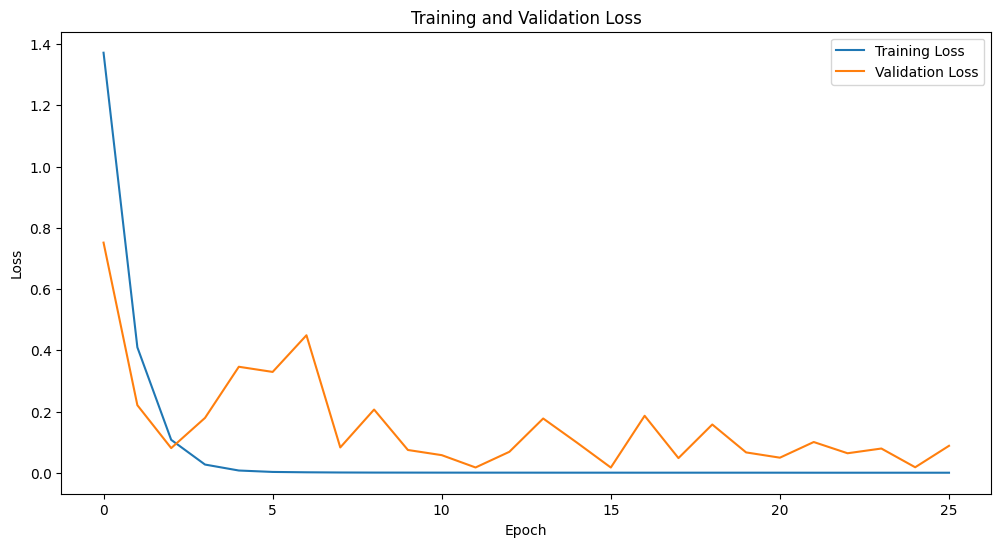

In [47]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [48]:

# Step 4: Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Train Loss: 0.0002
Validation Loss: 0.0172
Test Loss: 0.0951


In [49]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (5071, 30, 29)
Shape of y_train: (5071,)
Shape of X_test: (1585, 30, 29)
Shape of y_test: (1585,)


In [50]:
features

['Open',
 'High',
 'Low',
 'Volume',
 'close_delta',
 'open_delta',
 'high_delta',
 'low_delta',
 'volume_delta',
 'ema_8',
 'ema_21',
 'ema_34',
 'ema_55',
 'ema_89',
 'macd_line',
 'macd_signal_line',
 'macd_histogram',
 'squeeze_pro_indicator',
 'squeeze_pro_on_wide',
 'squeeze_pro_on_normal',
 'squeeze_pro_on_narrow',
 'squeeze_pro_off',
 'squeeze_pro_no',
 'squeeze_pro_increase',
 'squeeze_pro_decrease',
 'squeeze_pro_potential_increase',
 'squeeze_pro_potential_decrease',
 'squeeze_pro_negative_decrease',
 'squeeze_pro_negative_increase']

In [51]:
scalers

{'Open': MinMaxScaler(),
 'High': MinMaxScaler(),
 'Low': MinMaxScaler(),
 'Volume': StandardScaler(),
 'close_delta': MinMaxScaler(),
 'open_delta': MinMaxScaler(),
 'high_delta': MinMaxScaler(),
 'low_delta': MinMaxScaler(),
 'volume_delta': StandardScaler(),
 'ema_8': MinMaxScaler(),
 'ema_21': MinMaxScaler(),
 'ema_34': MinMaxScaler(),
 'ema_55': MinMaxScaler(),
 'ema_89': MinMaxScaler(),
 'macd_line': MinMaxScaler(),
 'macd_signal_line': MinMaxScaler(),
 'macd_histogram': MinMaxScaler(),
 'squeeze_pro_indicator': MinMaxScaler(),
 'squeeze_pro_on_wide': MinMaxScaler(),
 'squeeze_pro_on_normal': MinMaxScaler(),
 'squeeze_pro_on_narrow': MinMaxScaler(),
 'squeeze_pro_off': MinMaxScaler(),
 'squeeze_pro_no': MinMaxScaler(),
 'squeeze_pro_increase': MinMaxScaler(),
 'squeeze_pro_decrease': MinMaxScaler(),
 'squeeze_pro_potential_increase': MinMaxScaler(),
 'squeeze_pro_potential_decrease': MinMaxScaler(),
 'squeeze_pro_negative_decrease': MinMaxScaler(),
 'squeeze_pro_negative_increase

In [52]:
# Step 5: Make predictions
predictions = model.predict(X_test)

# Get the last sequence from X_train
last_train_sequence = X_train[-1]

# # Prepare the dummy array for inverse transformation
# dummy_pred = np.zeros((predictions.shape[0], X_train.shape[2]))
# dummy_pred[:] = last_train_sequence[-1]  # Fill with the last time step of the last training sequence
# dummy_pred[:, -1] = predictions.flatten()  # Replace the last column with predictions

print(f"Number of features: {len(features)}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of predictions: {predictions.shape}")
print(f"Number of scalers: {len(scalers)}")

50/50 [==============================] - 1s 8ms/step
Number of features: 29
Shape of X_test: (1585, 30, 29)
Shape of predictions: (1585, 1)
Number of scalers: 29


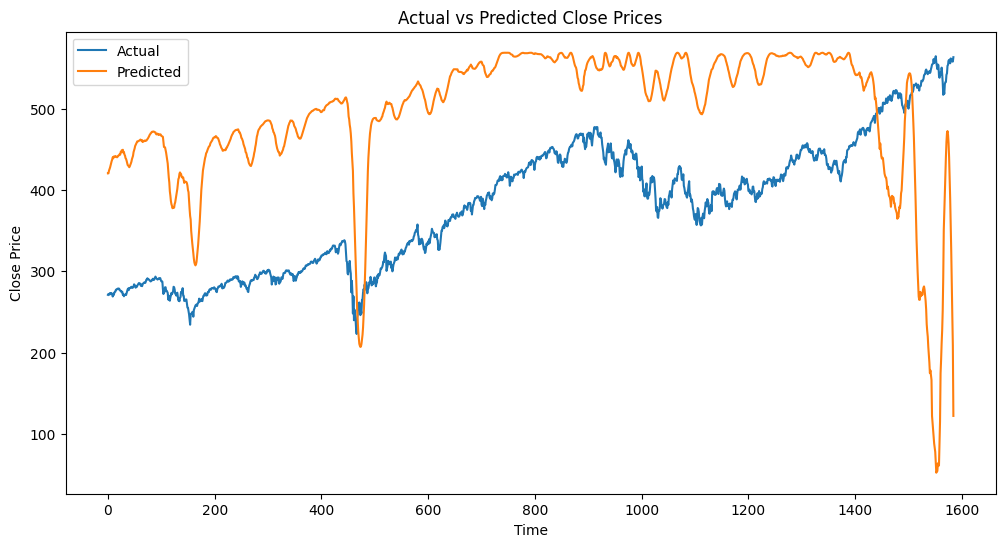

Mean Absolute Error: $150.41


In [53]:


# Inverse transform predictions
predicted_closes = target_scaler.inverse_transform(predictions).flatten()

# Prepare dummy array for actual values
dummy_actual = np.zeros((y_test.shape[0], len(features)))
dummy_actual[:] = last_train_sequence[-1]  # Fill with the last time step of the last training sequence
dummy_actual[:, -1] = y_test  # Replace the last column with actual values

# Inverse transform actual values
actual_closes = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(actual_closes, label='Actual')
plt.plot(predicted_closes, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()

# Calculate and print the Mean Absolute Error
mae = np.mean(np.abs(predicted_closes - actual_closes))
print(f"Mean Absolute Error: ${mae:.2f}")